In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Concatenate, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    TensorBoard, LearningRateScheduler
)
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, Multiply, Layer, Conv1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.experimental import CosineDecayRestarts
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.layers import Add, Multiply, GlobalAveragePooling1D
import seaborn as sns
import time
import os
from datetime import datetime
import pandas as pd

In [57]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.10.1
GPU Available: True


In [58]:
log_dir = "logs_MLP_nang_cao/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

In [59]:
checkpoint_dir = "checkpoints_MLP_nang_cao/"
os.makedirs(checkpoint_dir, exist_ok=True)

In [60]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [61]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the dataset: {unique_labels}")

Unique labels in the dataset: [0 1 2 3 4 5 6 7 8 9]


In [62]:
label_names = [
    "T-shirt/top",    # 0
    "Trouser",        # 1
    "Pullover",       # 2
    "Dress",          # 3
    "Coat",           # 4
    "Sandal",         # 5
    "Shirt",          # 6
    "Sneaker",        # 7
    "Bag",            # 8
    "Ankle boot"      # 9
]
for i, name in enumerate(label_names):
    print(f"{i}: {name}")

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


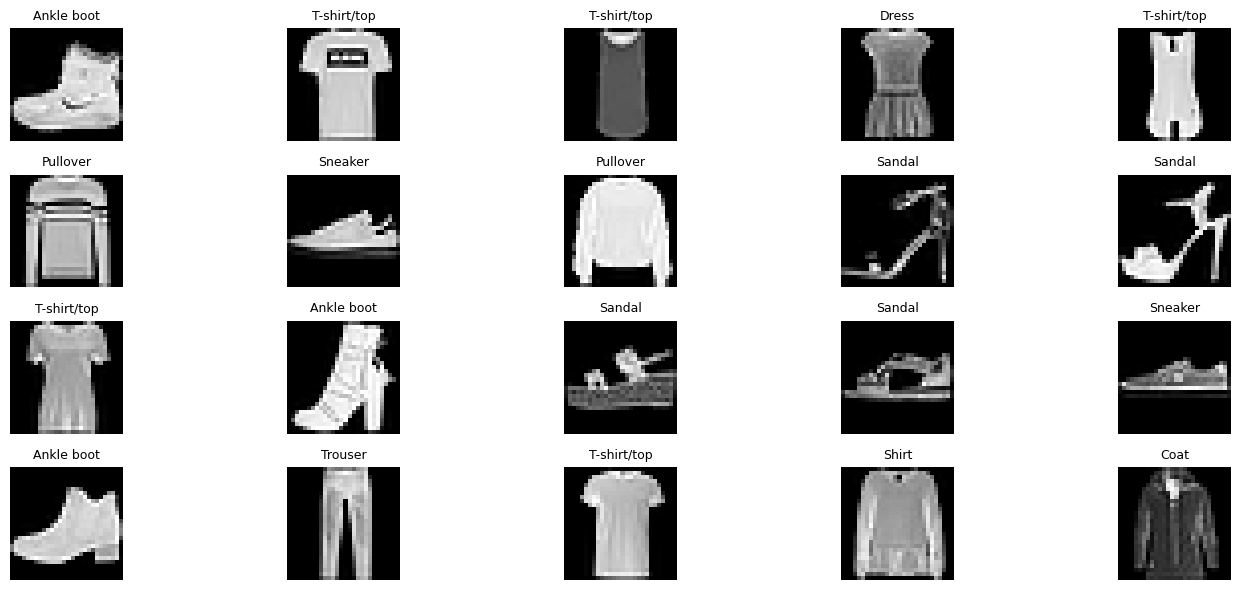

In [63]:
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(label_names[y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [64]:
class_names = ['Áo thun / Áo ngắn tay', 'Quần dài', 'Áo len chui đầu',
               'Váy liền thân', 'Áo khoác', 'Dép quai', 'Áo sơ mi',
               'Giày thể thao', 'Túi xách', 'Bốt cổ ngắn']

In [65]:
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [66]:
X_train = X_train.astype('float32') / 255.0
X_val = x_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [67]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [68]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [69]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [70]:
def create_advanced_mlp():
    inputs = Input(shape=(28, 28, 1))
    
    x = Flatten()(inputs)
    
    # Block 1
    x = Dense(1024, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Dropout(0.3)(x)
    
    #Block 2    
    block_input = x
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Dropout(0.3)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    
    block_input = Dense(512)(block_input)
    x = x + block_input
    
    #Block 3
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Dropout(0.2)(x)
    
    branch = Dense(256)(inputs if len(inputs.shape) == 2 else Flatten()(inputs))
    branch = BatchNormalization()(branch)
    branch = tf.nn.relu(branch)
    
    x = Concatenate()([x, branch])
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [71]:
def create_ensemble_mlp():
    # Input layer
    inputs = Input(shape=(28, 28, 1))
    flattened = Flatten()(inputs)
    
    # Mạng con 1: Sâu và hẹp
    net1 = Dense(512, activation='relu')(flattened)
    net1 = Dropout(0.3)(net1)
    net1 = Dense(256, activation='relu')(net1)
    net1 = Dropout(0.3)(net1)
    net1 = Dense(128, activation='relu')(net1)
    net1 = Dense(10, activation='softmax', name='net1_output')(net1)
    
    # Mạng con 2: Nông và rộng
    net2 = Dense(1024, activation='relu')(flattened)
    net2 = Dropout(0.4)(net2)
    net2 = Dense(512, activation='relu')(net2)
    net2 = Dense(10, activation='softmax', name='net2_output')(net2)
    
    # Mạng con 3: Kết hợp
    net3 = Dense(512, activation='selu')(flattened)
    net3 = Dense(256, activation='selu')(net3)
    net3 = Dropout(0.2)(net3)
    net3 = Dense(10, activation='softmax', name='net3_output')(net3)
    
    # Kết hợp các dự đoán
    ensemble_output = Lambda(lambda x: (x[0] + x[1] + x[2]) / 3.0)([net1, net2, net3])
    
    # Tạo mô hình với nhiều đầu ra
    model = Model(inputs=inputs, outputs=[ensemble_output, net1, net2, net3])
    return model

In [72]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.1
    if epoch > 60:
        lr *= 0.1
    return lr

In [73]:
advanced_mlp = create_advanced_mlp()
advanced_mlp.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 784)          0           ['input_4[0][0]']                
                                                                                                  
 dense_24 (Dense)               (None, 1024)         803840      ['flatten_6[0][0]']              
                                                                                                  
 batch_normalization_18 (BatchN  (None, 1024)        4096        ['dense_24[0][0]']               
 ormalization)                                                                              

In [74]:
callbacks = [
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_dir, 'model-{epoch:02d}-{val_accuracy:.4f}.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5+5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
    ),
    LearningRateScheduler(lr_schedule)
]

In [75]:
optimizer = Adam(learning_rate=1e-3)
advanced_mlp.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [76]:
batch_size = 128
epochs = 100

In [77]:
star_time = time.time()
history = advanced_mlp.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
421/421 [==============================] - ETA: 0s - loss: 1.0228 - accuracy: 0.7176 - top_3_accuracy: 0.9560 - precision_2: 0.8008 - recall_2: 0.6283
Epoch 1: val_accuracy improved from -inf to 0.80667, saving model to checkpoints_MLP_nang_cao\model-01-0.8067.h5
421/421 [==============================] - 13s 29ms/step - loss: 1.0228 - accuracy: 0.7176 - top_3_accuracy: 0.9560 - precision_2: 0.8008 - recall_2: 0.6283 - val_loss: 0.7339 - val_accuracy: 0.8067 - val_top_3_accuracy: 0.9800 - val_precision_2: 0.8690 - val_recall_2: 0.7338 - lr: 0.0010
Epoch 2/100
421/421 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.7594 - top_3_accuracy: 0.9720 - precision_2: 0.8231 - recall_2: 0.6914
Epoch 2: val_accuracy improved from 0.80667 to 0.81517, saving model to checkpoints_MLP_nang_cao\model-02-0.8152.h5
421/421 [==============================] - 12s 28ms/step - loss: 0.7927 - accuracy: 0.7594 - top_3_accuracy: 0.9720 - precision_2: 0.8231 - recall_2: 0.691

In [ ]:
test_loss, test_acc, test_top3_acc, test_precision, test_recall = advanced_mlp.evaluate(X_test, y_test)
print(f'\nKết quả đánh giá trên tập test:')
print(f'- Độ chính xác: {test_acc*100:.2f}%')
print(f'- Top-3 Accuracy: {test_top3_acc*100:.2f}%')
print(f'- Precision: {test_precision:.4f}')
print(f'- Recall: {test_recall:.4f}')
print(f'- Loss: {test_loss:.4f}')

313/313 [==============================] - 1s 4ms/step - loss: 0.3231 - accuracy: 0.8813 - top_3_accuracy: 0.9888 - precision_2: 0.9014 - recall_2: 0.8641

Kết quả đánh giá trên tập test:
- Độ chính xác: 88.13%
- Top-3 Accuracy: 98.88%
- Precision: 0.9014
- Recall: 0.8641
- Loss: 0.3231


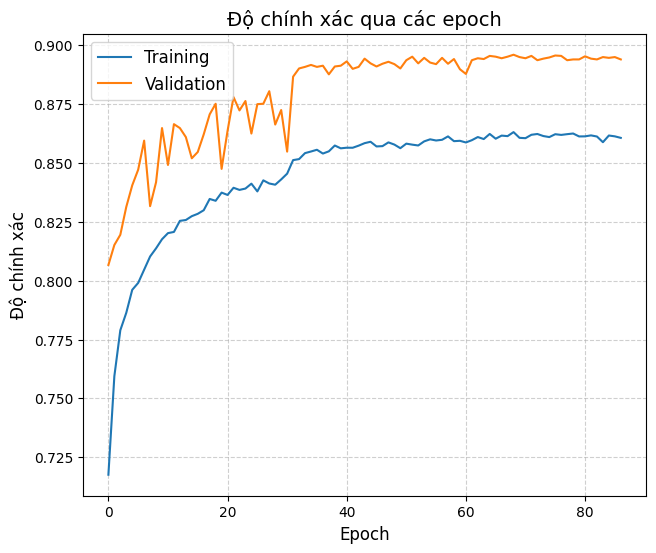

In [88]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Độ chính xác qua các epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

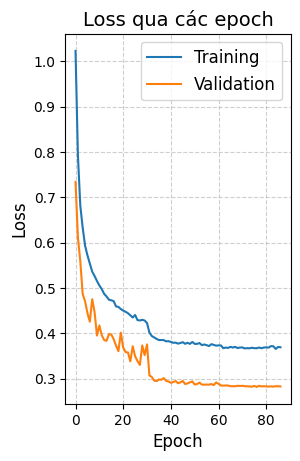

In [89]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss qua các epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

In [90]:
final_model_path = os.path.join(checkpoint_dir, 'fashion_mnist_final_model_MLP_nang_cao.h5')
advanced_mlp.save(final_model_path)
print(f"Đã lưu mô hình cuối cùng vào '{final_model_path}'")

Đã lưu mô hình cuối cùng vào 'checkpoints_MLP_nang_cao/fashion_mnist_final_model_MLP_nang_cao.h5'


In [91]:
predictions = advanced_mlp.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


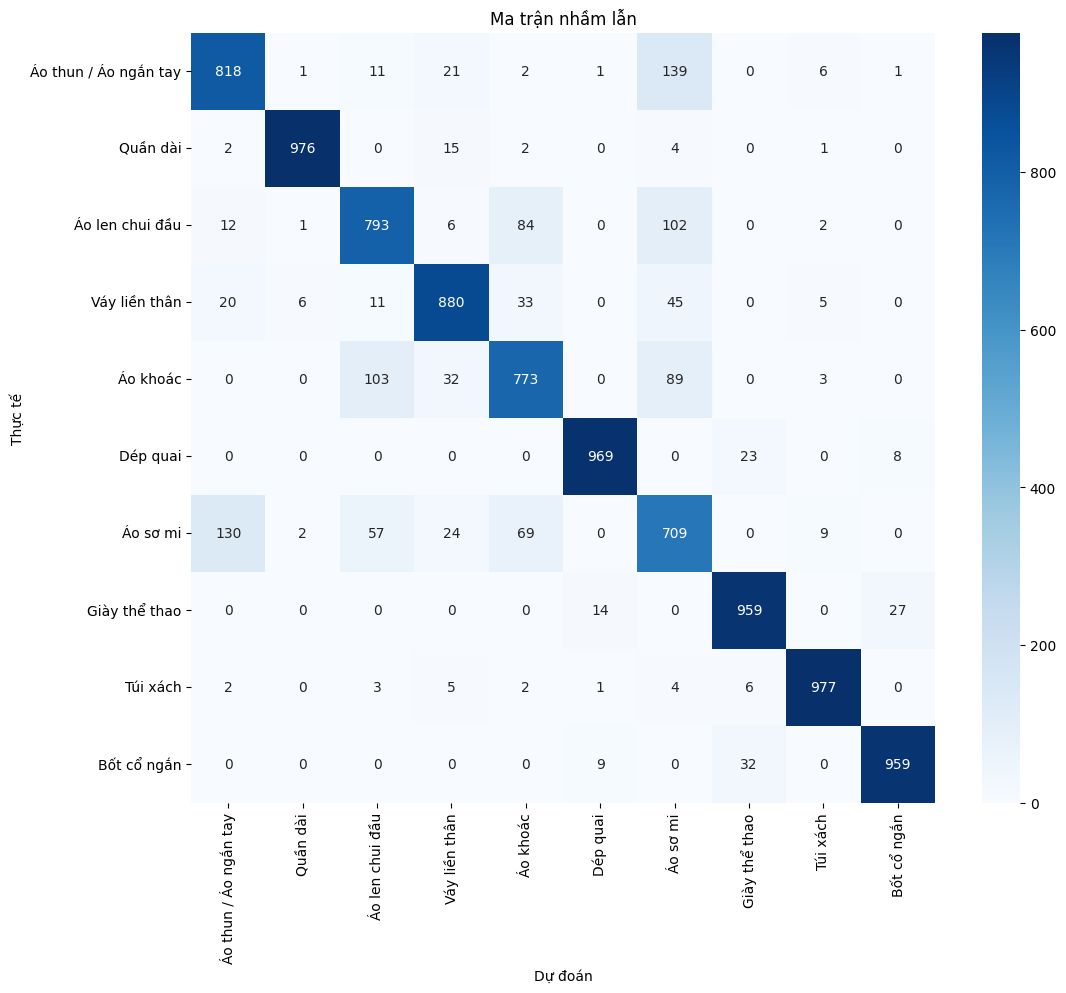

In [92]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

In [95]:
def plot_predictions(X, y_true, y_pred, class_names, num_samples=20):
    # Chọn ngẫu nhiên các mẫu
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    # Tạo lưới hình ảnh
    rows = int(np.ceil(num_samples / 5))
    fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i < len(axes):
            # Hiển thị hình ảnh
            axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
            
            # Thông tin dự đoán
            true_label = np.argmax(y_true[idx])
            pred_label = np.argmax(y_pred[idx])
            confidence = np.max(y_pred[idx]) * 100
            
            # Màu sắc tiêu đề dựa trên dự đoán đúng/sai
            color = 'green' if true_label == pred_label else 'red'
            
            # Tiêu đề cho hình ảnh
            title = f"Thực tế: {class_names[true_label]}\nDự đoán: {class_names[pred_label]}\nĐộ tin cậy: {confidence:.1f}%"
            axes[i].set_title(title, color=color, fontsize=9)
            axes[i].axis('off')
    
    # Ẩn các trục thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    plt.show()

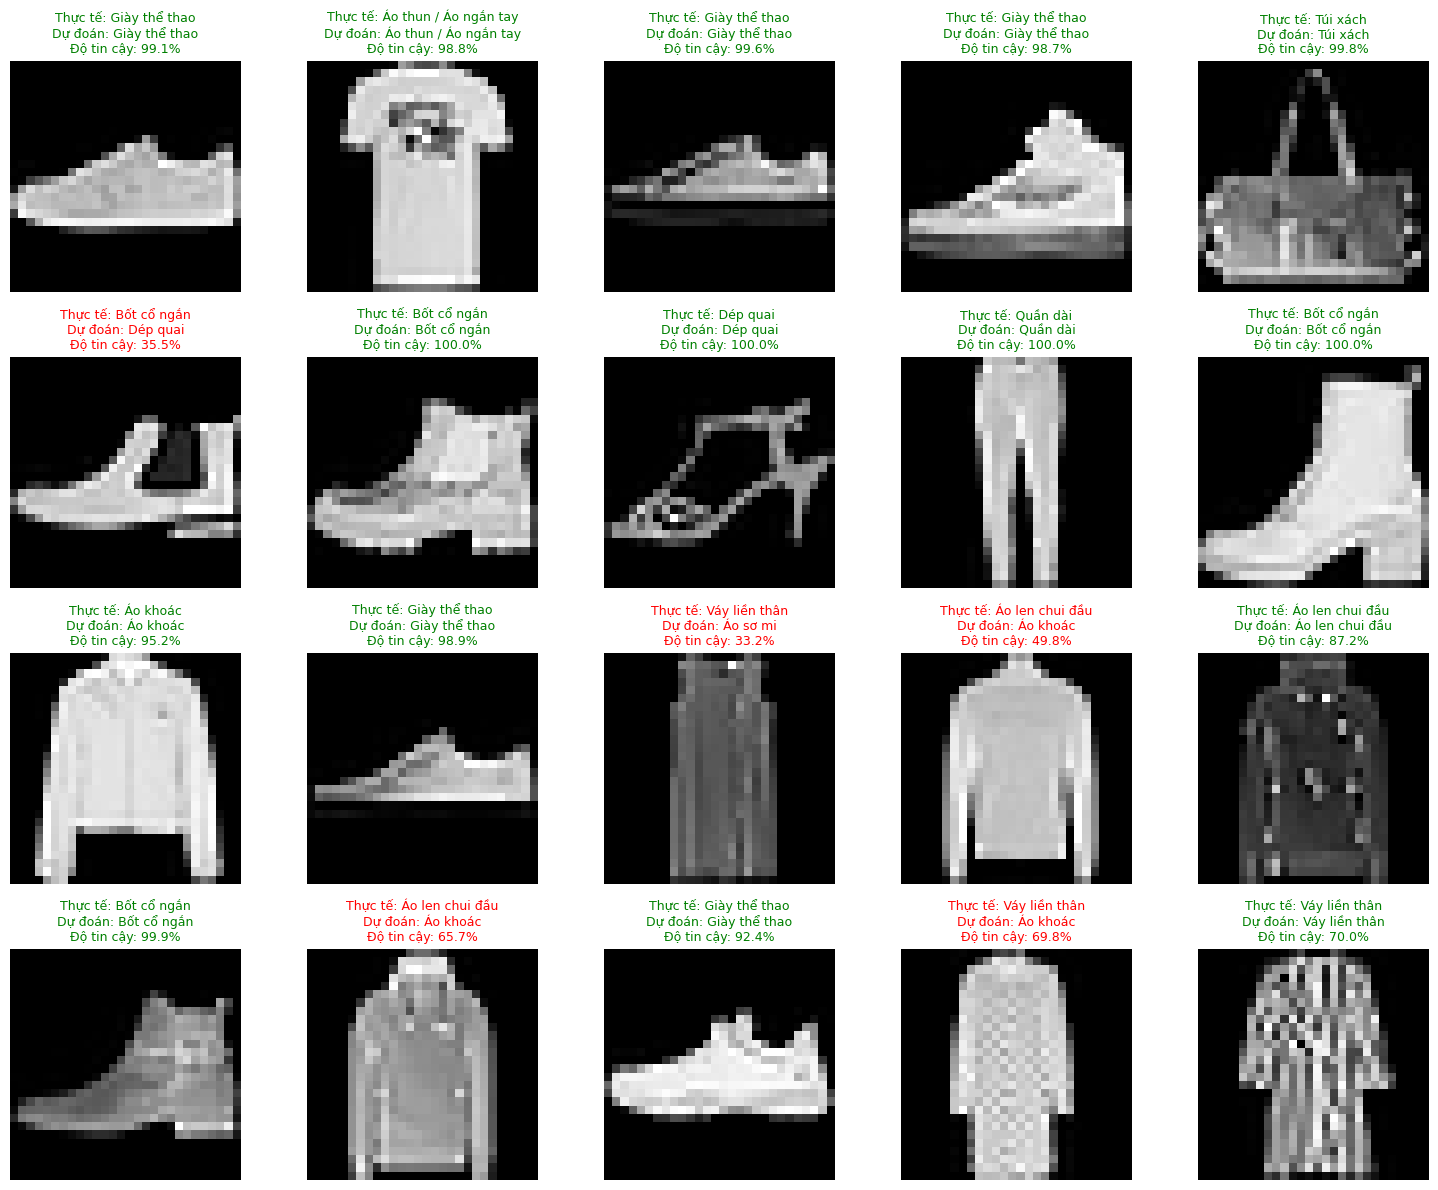

In [96]:
plot_predictions(X_test, y_test, predictions, class_names, num_samples=20)